In [0]:
# !pip install tqdm python_speech_features


**Visualizing CLass Distribution**





In [0]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa

In [0]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1


In [0]:
df = pd.read_csv('instruments.csv')

In [0]:
df.sample(10)

,fname,label
68,a090c45a.wav,Hi-hat
159,642ad7e4.wav,Double_bass
64,2503aaa1.wav,Hi-hat
86,aed9d22f.wav,Hi-hat
141,fc55d588.wav,Acoustic_guitar
57,21346775.wav,Violin_or_fiddle
160,5eadbc6d.wav,Double_bass
155,95e1d0ae.wav,Double_bass
89,468f9c4c.wav,Hi-hat
115,f1754aea.wav,Snare_drum


In [0]:
df.set_index('fname',inplace = True) ## setting fname as the index


In [0]:
df.sample(5)

,label
fname,
462b676f.wav,Double_bass
2424ad60.wav,Violin_or_fiddle
4c590f69.wav,Snare_drum
deb87700.wav,Double_bass
b68f10af.wav,Snare_drum


In [0]:
for f in df.index :
    rate , signal = wavfile.read('wavfiles/'+f)

    df.at[f,'length'] = signal.shape[0]/rate
    ## signal.shape[0] == length of the signal
    ## rate == sampling rate
    ## signal.shape[0]/rate == len of signal in seconds

In [0]:
df.sample(5)

,label,length
fname,,
00353774.wav,Cello,4.52
b88322f6.wav,Acoustic_guitar,4.18
642aba58.wav,Violin_or_fiddle,1.30
4fb480bf.wav,Double_bass,8.74
3aafb6ad.wav,Hi-hat,4.18


In [0]:
classes = list(np.array(df.label.unique()))
print(classes)

##GroupBy label and calculate the mean length of each group
class_dis = df.groupby(['label'])['length'].mean()

['Saxophone', 'Violin_or_fiddle', 'Hi-hat', 'Snare_drum', 'Acoustic_guitar', 'Double_bass', 'Cello', 'Bass_drum', 'Flute', 'Clarinet']


In [0]:
#class distribution of musical instruments
class_dis

label
Acoustic_guitar     6.948667
Bass_drum           1.937333
Cello               5.000667
Clarinet            6.596000
Double_bass         3.206000
Flute               8.054667
Hi-hat              3.357333
Saxophone           7.124000
Snare_drum          3.987333
Violin_or_fiddle    4.530000
Name: length, dtype: float64

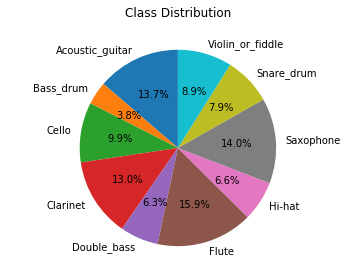

In [0]:
#Visualize Class Distribution
fig , ax = plt.subplots()
ax.set_title("Class Distribution" , y = 1.08)
ax.pie(class_dis , labels = class_dis.index , autopct = '%1.1f%%' , shadow = False , startangle = 90)
ax.axis('equal')
plt.show()

df.reset_index(inplace = True)



In [0]:
#########################################################################################

**Preprocessing**

In [0]:
signals = {}
fft = {}
fbank = {}
mfccs = {}


In [0]:
def calc_fft(signal , rate) :
    n = len(signal)
    freq = np.fft.rfftfreq( n , d = 1/rate)     ##calculate the real fft 
    magnitude = abs(np.fft.rfft(signal)/n)       ##rfft returns complex , therefore take absolute val ,..Divide by n to normalize
    return (magnitude , freq)

In [0]:
def  envelope(signal , rate , threshold) :
    mask=[]
    y = pd.Series(signal).apply(np.abs)
    y_mean = y.rolling(window = int(rate/10) , min_periods = 1 , center = True).mean()
    
    for mean in y_mean :
        if(mean > threshold) :
            mask.append(True)
        else :
            mask.append(False)
    return mask

In [0]:
for c in classes :
    wav_file = df[df.label == c].iloc[0,0] ##pick a example from each class
    signal , rate = librosa.load('wavfiles/' + wavfile , sr = 44100)    ##sr == sampling rate
    
    mask = envelope(signal , rate , 0.0005)    ##creating envelope on signal
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calc_fft(signal , rate)
    
    
    
    bank = logfbank(signal[:rate] , rate , nfilt = 26 , nfft = 1103).T
    fbank[c] = bank
    
    mel = mfcc(signal[:rate] , rate , numcep = 13 , nfilt = 26 , nfft = 1103).T
    mfccs[c] = mel
    
 

####Without Envelope####





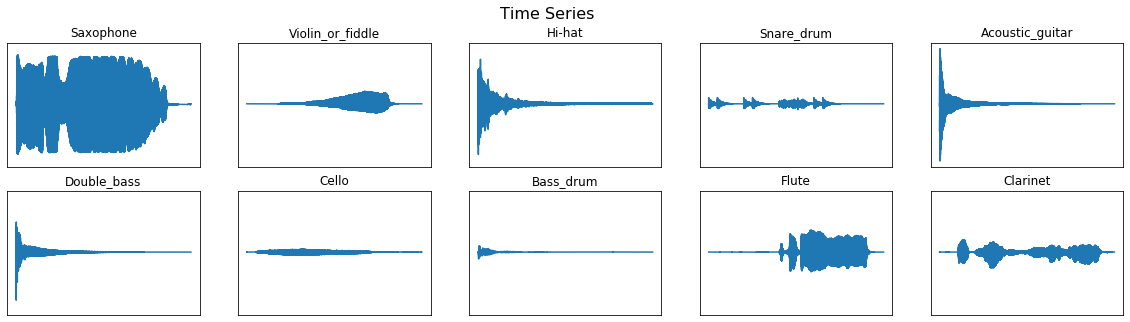

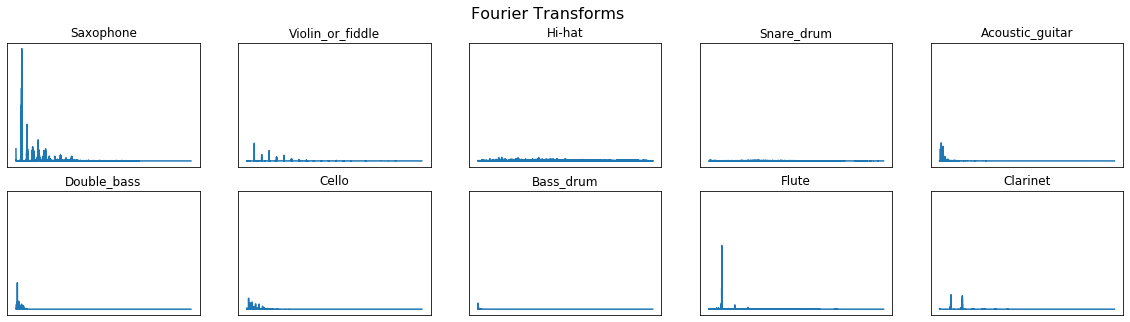

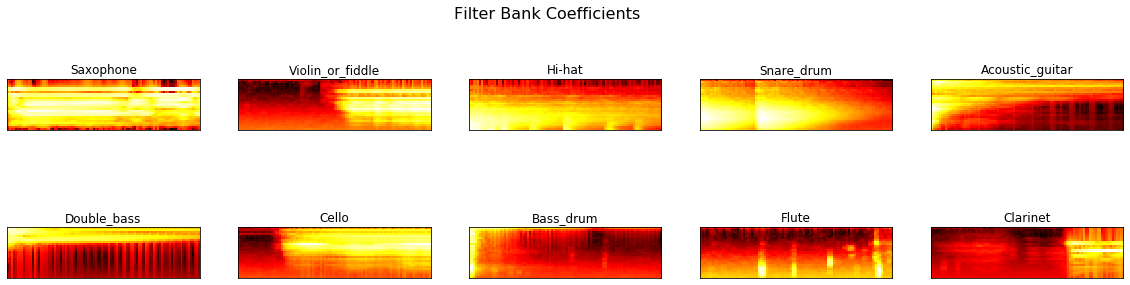

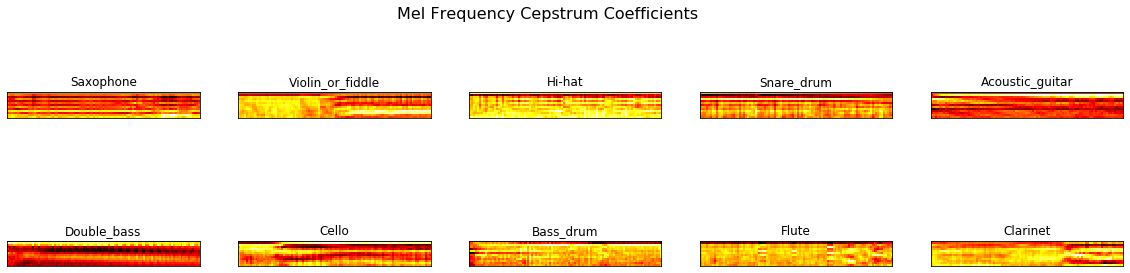

In [0]:
plot_signals(signals)
plot_fft(fft)
plot_fbank(fbank)
plot_mfccs(mfccs)

####With Envelope####

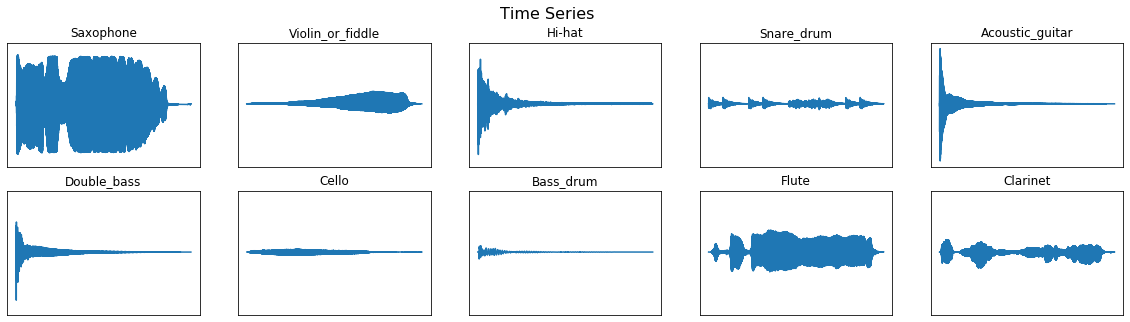

In [0]:

plot_signals(signals)


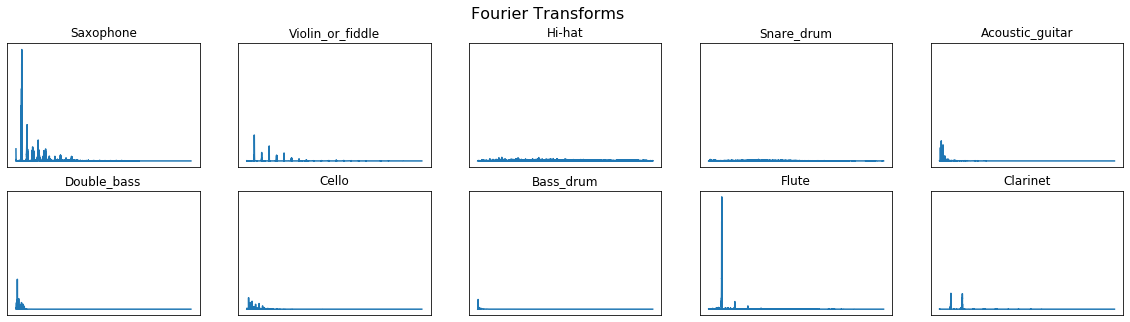

In [0]:
plot_fft(fft)

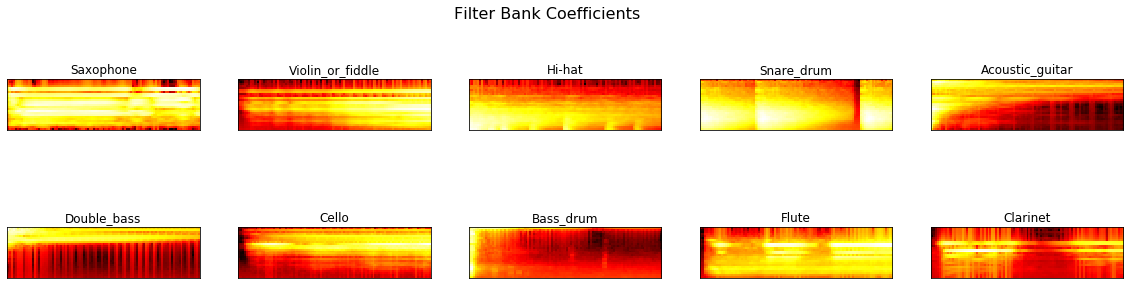

In [0]:
plot_fbank(fbank)

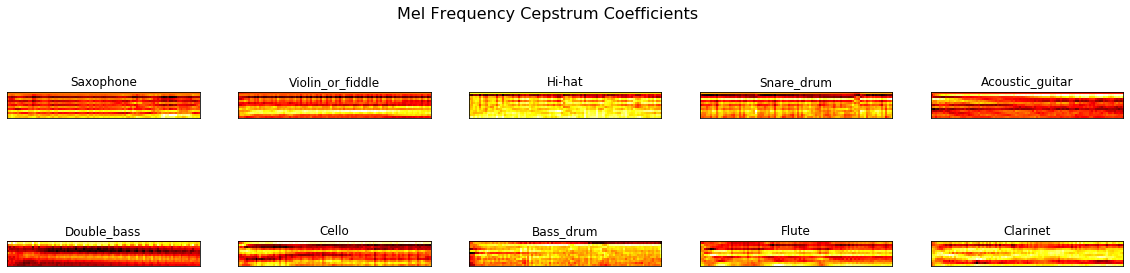

In [0]:
plot_mfccs(mfccs)

In [0]:
#####DownSampling Signal , coz we dont usually deal with high freqs#############

In [0]:
if len(os.listdir("clean")) == 0 :
    for f in tqdm(df.fname):
        signal , rate = librosa.load("wavfiles/" +f , sr = 16000)   ##here sr is decreased for neglecting very high freq
        mask = envelope(signal , rate , 0.0005)
        wavfile.write(filename = "clean/" + f , rate = rate , data = signal[mask])
        

100%|██████████| 300/300 [02:05<00:00,  2.52it/s]
